# Third exercise (Chapter 5)

In this exercise we consider Chapter 5 of the book "Deep Learning". The exercise focuses on Linear Regression. We will implement various ways of finding the model weights:

* The Analytical Method
* Stochastic Gradient Descent
* Bayesian Linear Regression (which also has a specific predict method)

In the following code block, all necessary imports are provided as well as the data generators. 

In [1]:
# some imports
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

# data generation
def data_1d():
    # generates y data according to the example in Figure 5.1. 
    
    # the data generator; Input: np.array of shape (1)
    def generator(x):
        # data checking
        if isinstance(x, list):
            x = np.array(x)
        if len(x.shape) != 1 or len(x) != 1:
            raise ValueError('x should be a vector of size 1')
        return 1.5 * x[0] + np.random.normal(0.0, 0.1)
    
    # the data
    X_train = np.array([[-0.4], [-0.35], [-0.3], [-0.3], [-0.2], [0.1], [0.2], [0.3], [0.4], [0.6]])
    y_train = np.array([generator(X_train[i]) for i in range(len(X_train))])
    return X_train, y_train


def data_2d(noise_rate = 0.1):
    # generates random data according to the function y = 1.5 * x1 + 0.5 * x2 + epsilon  
    def generator(x):
        # data checking
        if isinstance(x, list):
            x = np.array(x)
        if len(x.shape) != 1 or len(x) != 2:
            raise ValueError('x should be a vector of size 2')
        return 1.5 * x[0] + 0.5 * x[1] + np.random.normal(0.0, noise_rate)

    data_n = 40
    X_train = np.reshape(np.random.random(data_n * 2), (data_n, 2))
    y_train = np.array([generator(X_train[i]) for i in range(len(X_train))])
    return X_train, y_train


## Misc

Finish the following function

* predict(x, w): accepts x (numpy array or a list of floats) and w (idem) and returns the dot product of these. Note that according to eq. 5.13 there is also a bias term b, but these is left out for the sake of simplicity. From an implementation point of view, this one could be added by adding a column to the dataset with constant value 1. 

In [4]:
def predict(x, w):
    # predicts y_hat for a single data point, based on x and the learned weights
    
    if isinstance(x, list):
        x = np.array(x)
    if isinstance(w, list):
        w = np.array(w)
    
    # data checking
    if x.shape != w.shape:
        raise ValueError('x and w should have same dimensions')
    if len(x.shape) > 1:
        raise ValueError('x should be a vector (1d array)')
    
    return np.dot(x, w)

Finish the following function

* mse(X, y, w): accepts X (2 dimensional numpy array), y (1 dimensional numpy array) and w (1 dimensional numpy array) and calculates the mean squared error of the linear regression model defined by w based on testset (X, y). For this, you can use equation 5.5. 

In [25]:
def mse(X, y, w):
    if not (isinstance(X, np.ndarray) and isinstance(y, np.ndarray) and isinstance(w, np.ndarray)):
        raise ValueError('inputs should be numpy arrays')
    if len(X.shape) != 2:
        raise ValueError('X should be 2d array')
    if len(y.shape) != 1:
        raise ValueError('y should be 1d array')
    if len(w.shape) != 1:
        raise ValueError('w should be 1d array')
    if X.shape[0] != y.shape[0]:
        raise ValueError('num instances in X should match length of y')
    if X.shape[1] != w.shape[0]:
        raise ValueError('num attributes in X should match length of w')
    
    y_hat = np.dot(X, w)
    m = y.shape[0]
    return np.linalg.norm(y_hat - y) ** 2 / m

## The Analytical Method

First, we will implement Linear Regression according to eq. 5.12 (see slide 16). We will produce an image much like Figure 5.1. Note that the data according to the function data_1d (loaded in the cell below) is quite similar (but due to the random factor not exactly the same) as the data provided in Figure 5.1 left. 

In [6]:
X_train, y_train = data_1d()

Finish the following function

* linreg_vanilla(X, y) accepts X (2 dimensional numpy array), y (1 dimensional numpy array) and calculates the weights for the linear regression model based on the train set (X, y) according to eq. 5.12. Note that numpy has built in functions for matrix inversion, multiplication and transposing. 

In [10]:

def linreg_vanilla(X, y):
    X_t = np.transpose(X)
    return np.linalg.multi_dot([
        np.linalg.inv(np.dot(X_t, X)),
        X_t,
        y
    ])


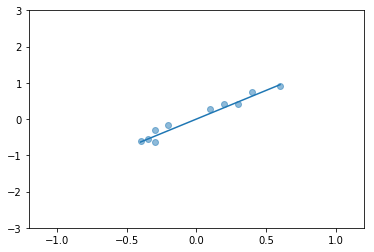

In [19]:
%matplotlib inline

w = linreg_vanilla(X_train, y_train).reshape((1, -1))
plt.plot(X_train, np.dot(w, np.transpose(X_train)).transpose(), '-')

plt.xlim(-1.2, 1.2)
plt.ylim(-3, 3)
plt.scatter(X_train[:,0], y_train, alpha=0.5)
plt.show()

Reproduce figure 5.1 (right). For this, we need to calculate the Mean Squared Error (MSE) of various values for the weight and plot the resulting curve. Note that the optimal value might differ, due to the random factor in the data. 

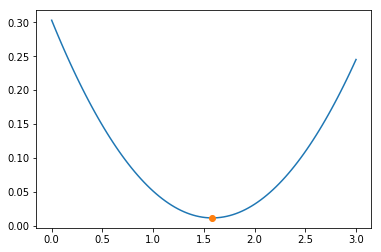

In [46]:
# generate a curve like Figure 5.1 (right)
w = np.linspace(0, 3, 100)
error = np.vectorize(lambda ww: mse(X_train, y_train, np.array(ww).reshape((1,))))(w)
plt.plot(w, error)
ind = np.argmin(error)
plt.plot(w[ind], error[ind], 'o')

Now we want to make sure that the model also works on a more complicated dataset. For this, we will use the provided 2-d dataset. Make sure the model comes approximately to the right values and draw contour plots of the possible weight values. 

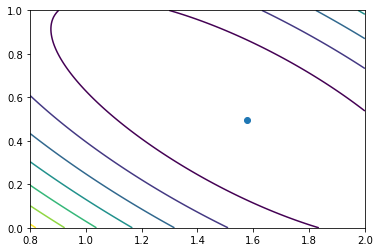

In [69]:
X_train, y_train = data_2d()

# make a contour plot of the weight values based on the 2-D data.

w_1 = np.linspace(0.8, 2, 100)
w_2 = np.linspace(0, 1, 100)
grid_1, grid_2 = np.meshgrid(w_1, w_2)
error = np.vectorize(lambda w1, w2: mse(X_train, y_train, np.array([w1, w2])))(grid_1, grid_2)
plt.contour(grid_1, grid_2, error)

flat_ind = np.argmin(error)
ind = np.unravel_index(flat_ind, error.shape)
plt.plot(grid_1[ind], grid_2[ind], 'o')

## Stochastic Gradient Descent

In many cases, determining the weights in an analytical fashion takes too much time. In order to overcome this, we can use Stochastic Gradient Descent, which we will implement next. It is explained in Section 5.9 (see slide 23). 

The most important part of SGD is a step function, that moves the solution in the direction of the gradient. This is given in eq. 5.98. 

Finish the following function:

* update_fn, accepting weights (1 dimensional numpy array), x (2 dimensional numpy array) y (1 dimensional array) and learning rate (float). It returns a new weight vector, of the same dimensions as weights. 

In [95]:
def update_fn(weights, X, y, learningRate=1.0):
    if isinstance(weights, list):
        weights = np.array(weights)
    if isinstance(X, list):
        X = np.array(X)
    if isinstance(y, list):
        y = np.array(y)
    if X.shape[1] != len(weights):
        raise ValueError()
    if X.shape[0] != len(y):
        raise ValueError()
    
    # first calculate (batch) gradient:
    w = weights
    y_hat = np.dot(X, w)
    g = 2 * (np.dot(y_hat - y, X))
    # sgd step
    weights -= learningRate * g
    return weights

After the update function has been defined, it is a matter of drawing randomly examples and making steps according to the error of the current weights on this example. This is illustrated below. 

In [112]:
X_train, y_train = data_2d()
print(X_train.shape, y_train.shape)

num_iterations = 50
mini_batch_size = len(X_train)
learning_rate = 0.01
weights = np.array([0.0, 0.0])
w_1 = []
w_2 = []
error = []
for i in range(num_iterations):
    inst_ids = np.random.choice(np.arange(len(X_train)), size=mini_batch_size, replace=False)
    weights = update_fn(weights, X_train[inst_ids], y_train[inst_ids], learning_rate)
    w_1.append(weights[0])
    w_2.append(weights[1])
    error.append(mse(X_train, y_train, weights))
    # print(weights)

print('results', weights)

(40, 2) (40,)
results [ 1.41448673  0.52048398]


Construct the following plots: 

* the trajectory of the algorithm, showing how the weights evolve as more steps are taken
* the learning curve, showing how the error goes down as more steps are taken

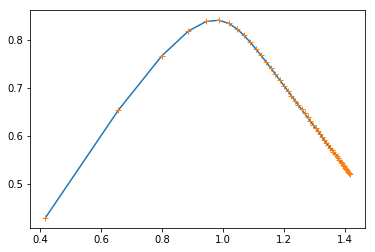

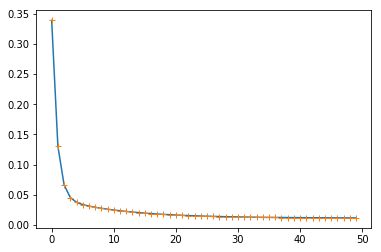

In [113]:
# draw the trajectory

plt.plot(w_1, w_2)
plt.plot(w_1, w_2, '+')

# draw learning curve
plt.figure()
plt.plot(error)
plt.plot(error, '+')

## Bayesian Linear Regression

Next, we are going to implement Bayesian Linear Regression, according to eq. 5.78 (see slide 28). This formula looks quite complicated, but in fact it is a Gaussian (as implemented in, e.g., scipy.stats.multivariate_normal). In order to initiate this, all we need is to define the priors, given by **$\mu_m$** and $\Lambda_m$. 

Finish the following function

* linreg_bayes, accept mu0 (1 dimensional numpy array), lambda0 (2 dimensional numpy array), X (2 dimensional numpy array) and y (1 dimensional numpy array), and returns a scipy distribution

In [116]:
from scipy.stats import multivariate_normal

def linreg_bayes(mu0, lambda0, X, y):
    if isinstance(mu0, list):
        mu0 = np.array(mu0)
    if isinstance(lambda0, list):
        lambda0 = np.array(lambda0)
    if isinstance(X, list):
        X = np.array(X)
    if isinstance(y, list):
        y = np.array(y)
    
    if len(X.shape) != 2 or len(y.shape) != 1 or len(mu0.shape) != 1 or len(lambda0.shape) != 2:
        raise ValueError()
    if X.shape[0] != y.shape[0]:
        raise ValueError()
    if not (X.shape[1] == mu0.shape[0] == lambda0.shape[0] == lambda0.shape[1]):
        raise ValueError()
    
    cov = np.linalg.inv(np.dot(X.transpose(), X) + np.linalg.inv(lambda0))
    mean = np.dot(cov, (np.dot(X.transpose(), y) + np.dot(np.linalg.inv(lambda0), mu0)))
    
    return multivariate_normal(mean=mean, cov=cov)

We can test whether this works as expected by running it on the previously provided 1d dataset. Note that we do not have a single set of weights, but rather we sample from the distribution. The mean of this sample should be in the same order as the values that were obtained analytically. It depends on the quality of the priors how close this will be. 

Avg weight value (sample) 1.26597509294


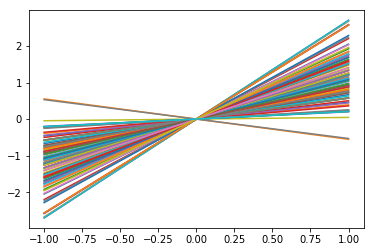

In [119]:
X_train, y_train = data_1d()
lambda0 = np.array([[1.0]])
mu0 = np.array([1.0])

distr = linreg_bayes(mu0, lambda0, X_train, y_train)

samples = distr.rvs(size=1000)
print('Avg weight value (sample)', samples.mean())
x = np.linspace(-1.0, 1.0, 100)

for i in range(100):
    weight = distr.rvs()
    y = weight * x
    plt.plot(x, y)

# plt.scatter(X_train[:,0], y_train, alpha=0.5)
plt.show()

Now we want to try the model on the 2-dimensional dataset. We can visualise the probabilities of the weights. 

Obtained values 1.35622699534 0.604771250986


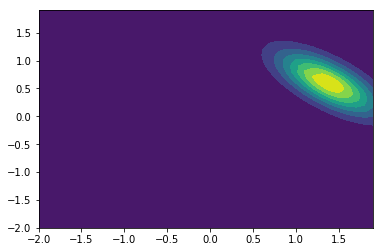

In [120]:
X_train, y_train = data_2d()
lambda0 = np.array([[1.0, 0.0], [0.0, 1.0]])
mu0 = np.array([1.0, 1.0])

distr = linreg_bayes(mu0, lambda0, X_train, y_train)

samples = distr.rvs(size=1000)
print('Obtained values', samples[:, 0].mean(), samples[:, 1].mean())

delta = 0.1
x, y = np.mgrid[-2:2:delta, -2:2:delta]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x
pos[:, :, 1] = y
plt.contourf(x, y, distr.pdf(pos))
plt.show()


## Feedback / survey

### Ex. 1
(1), (2), (3), (4): not at all

Reason: Too easy, mainly fiddling with array dinemensions. I think everyone should already have seen something like this in their studies.

Time: 15 min

### Ex. 2
(1), (2), (3), (4), (5): not at all / not very

Reason: Same as above: if the lab course is mandatory for everyone, it might be better not to create too much overlap.

Time: 45 min (again the dimensions...)

### Ex. 3
(1), (2), (3): quite

Reason: nice exercise, hadn't seen Bayesian linear regression before.

Time: 45 min including reading

### General feedback to the exercises:
+ pos: simple examples that just show the central concepts in cases in which you can still visualise them.
+ neg: just implementing a formula like in ex. 3 does not really create understanding for me. Better to prove some properties, do part of the derivation etc.